In [1]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Mounted at /content/drive


In [1]:
START_IDX = 0
saved_model_name = 'siamese_full.pt'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

import os
import random
import gc
from tqdm import tqdm

from utils import *
from models.siam_nested_unet import Siam_NestedUNet_Conc
from datasets.dataset import ChangeDetectionDataset

## Read Data


In [4]:
training_path = './trainval/'

In [5]:
after_images = read_data(training_path, 'after',START_IDX)
before_images = read_data(training_path,'before',START_IDX)
labels = read_data(training_path,'label',START_IDX)

Time taken to read  after  images: 160.08 seconds
Time taken to read  before  images: 175.01 seconds
Time taken to read  label  images: 151.35 seconds


In [6]:
# diff_images = read_data(training_path,'diff',START_IDX)
# labels = read_data(training_path,'label',START_IDX)

In [7]:
print(len(before_images))
print(len(after_images))
print(len(labels))

4868
4868
4868


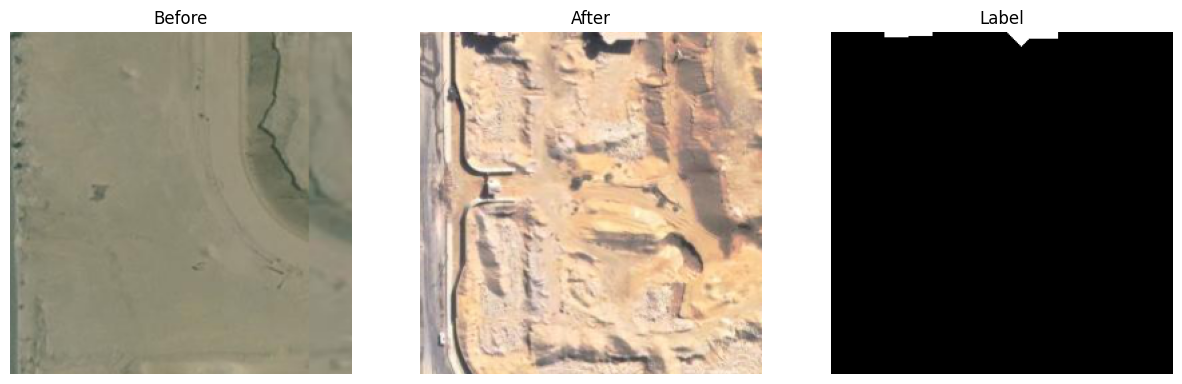

In [ ]:
index = 0
display_images([before_images[index], after_images[index]], labels[index])

## Create Datasets


In [8]:
batch_size = 16
train_val_ratio = 0.8

In [9]:
# Define transformations
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDataset(before_images, after_images, labels, transform_rgb, transform_label)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle = True)
# val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [ ]:
# del before_images
# del after_images
# del labels
# gc.collect()

In [11]:
print("Percentage of pure black masks in training set:", count_pure_black_masks(train_loader))
# print("Percentage of pure black masks in validation set:", count_pure_black_masks(val_loader))

Percentage of pure black masks in training set: 66.39276910435498


In [12]:
print("Train size:", len(train_loader) * batch_size)
# print("Validation size:", len(val_loader) * batch_size)

Train size: 4880


In [13]:
# before_images, after_images, label = train_dataset[0]
# print(before_images.shape)
# print(after_images.shape)
# print(label.shape)

In [14]:
# Create an instance of the model, label_nbr
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Siam_NestedUNet_Conc(in_ch=3, out_ch=1).to(device)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [16]:
learning_rate = 0.001
threshold = 0.3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
# from torchsummary import summary
# summary(model,input_size=[(3,256,256),(3,256,256)])

## Train Model


In [18]:
def train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=50, save_dir="saved_models"):
    n_steps = len(train_loader)
    jaccard_loss = 0.0
    best_jaccard_score = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_iou = 0.0

        predicted_masks_list = []
        true_masks_list = []
        for data in tqdm(train_loader):
            before_image, after_image, true_masks = data
            before_image = before_image.to(device)
            after_image = after_image.to(device)
            true_masks = true_masks.to(device)

            optimizer.zero_grad()
            masks_pred = model(before_image, after_image)  # Pass both before and after images to the model
            loss = criterion(masks_pred, true_masks)
            loss += 0.6 * jaccard_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            pred_masks = (masks_pred > threshold).float()

            for i, pred_mask in enumerate(pred_masks):
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = true_masks[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

            # Clearing unnecessary variables from GPU memory
            del before_image, true_masks, masks_pred, loss

        epoch_iou, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
        epoch_loss = running_loss / n_steps
        jaccard_loss = 1 - epoch_iou

        print(f'Epoch [{epoch + 1}/{num_epochs}] Finished, Loss: {epoch_loss:.5f}, Jaccard Index: {epoch_iou*100:.3f}%, Accuracy: {overall_accuracy*100:.3f}%, Learning Rate: {optimizer.param_groups[0]["lr"]}')
        # Step the scheduler based on the validation IoU
        scheduler.step()

        model_path = os.path.join(save_dir, saved_model_name)
        if epoch_iou > best_jaccard_score:
            best_jaccard_score = epoch_iou
            print(f'Best Jaccard Index: {best_jaccard_score*100:.5f}%')
            torch.save(model.state_dict(), model_path)

        running_loss = 0.0

In [19]:
# Train the model
train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=10, save_dir= "saved_models")

100%|██████████| 305/305 [06:32<00:00,  1.29s/it]


Epoch [1/10] Finished, Loss: 0.49021, Jaccard Index: 13.098%, Accuracy: 93.036%, Learning Rate: 0.001
Best Jaccard Index: 13.09765%


100%|██████████| 305/305 [06:31<00:00,  1.28s/it]


Epoch [2/10] Finished, Loss: 0.65150, Jaccard Index: 36.349%, Accuracy: 94.850%, Learning Rate: 0.001
Best Jaccard Index: 36.34916%


100%|██████████| 305/305 [06:31<00:00,  1.28s/it]


Epoch [3/10] Finished, Loss: 0.50162, Jaccard Index: 51.180%, Accuracy: 95.180%, Learning Rate: 0.001
Best Jaccard Index: 51.18013%


 29%|██▉       | 88/305 [01:54<04:42,  1.30s/it]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # Load the latest saved model
model = load_model(model, save_dir="saved_models", model_name=saved_model_name)

In [ ]:
class BinaryConfusionMatrix():
    def __init__(self):
        super(BinaryConfusionMatrix, self).__init__()
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0

    def update(self, pred: torch.Tensor, target: torch.Tensor) -> None:
        self.tp += ((target == pred) & (target == 1)).sum().item()
        self.fp += ((target != pred) & (target == 0)).sum().item()
        self.tn += ((target == pred) & (target == 0)).sum().item()
        self.fn += ((target != pred) & (target == 1)).sum().item()

    def compute(self) -> torch.Tensor:
        return torch.tensor([self.tp, self.fp, self.tn, self.fn]).view(2, 2)

    def reset(self) -> None:
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0

    def get_jaccard(self) -> float:
        union = self.tp + self.fp + self.fn
        return self.tp / union if union > 0 else 1.0


In [ ]:
confusion_matrix = BinaryConfusionMatrix()

In [ ]:
def validate_new(model, test_loader, device, threshold = 0.3):
    before_images_list = []
    after_images_list = []
    predicted_masks_list = []
    true_masks_list = []

    with torch.no_grad():
        for data in tqdm(test_loader):
            before_image, after_image, label = data

            before_image = before_image.to(device)
            after_image = after_image.to(device)
            label = label.to(device)

            outputs = model(before_image, after_image)

            # Apply threshold to model outputs
            pred_masks = (outputs > threshold).float()
            confusion_matrix.update(pred_masks,label)
            for i, pred_mask in enumerate(pred_masks):
                before_images_list.append(before_image[i].cpu())
                after_images_list.append(after_image[i].cpu())

                # Save binary predicted mask
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = label[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

    return before_images_list, after_images_list, predicted_masks_list, true_masks_list


## Validate Model


In [ ]:
before_images_list, after_images_list, predicted_masks_list, true_masks_list = validate_new(model, val_loader, device, threshold)

100%|██████████| 61/61 [00:31<00:00,  1.96it/s]


In [ ]:
confusion_matrix.compute()

tensor([[ 3157440,   663583],
        [58936728,  1074313]])

In [ ]:
confusion_matrix.get_jaccard()

0.6449894348416534

In [ ]:
jaccard, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
print("Validation")
print(f"Mean Jaccard Index :{jaccard*100:.5f}%")
# print(f"Overall Accuracy : {overall_accuracy*100:.5f}%")

Validation
Mean Jaccard Index :80.30303%


In [ ]:
display_predicted_images(before_images_list, after_images_list, predicted_masks_list, true_masks_list)

In [ ]:
# save_predictions(predicted_masks_list, predicted_images_dir)